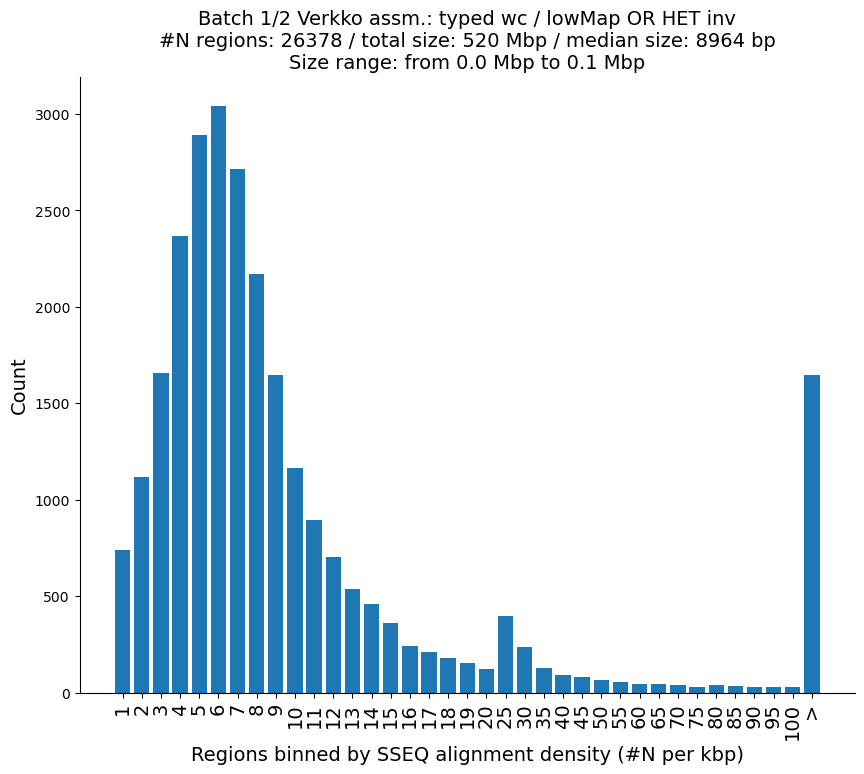

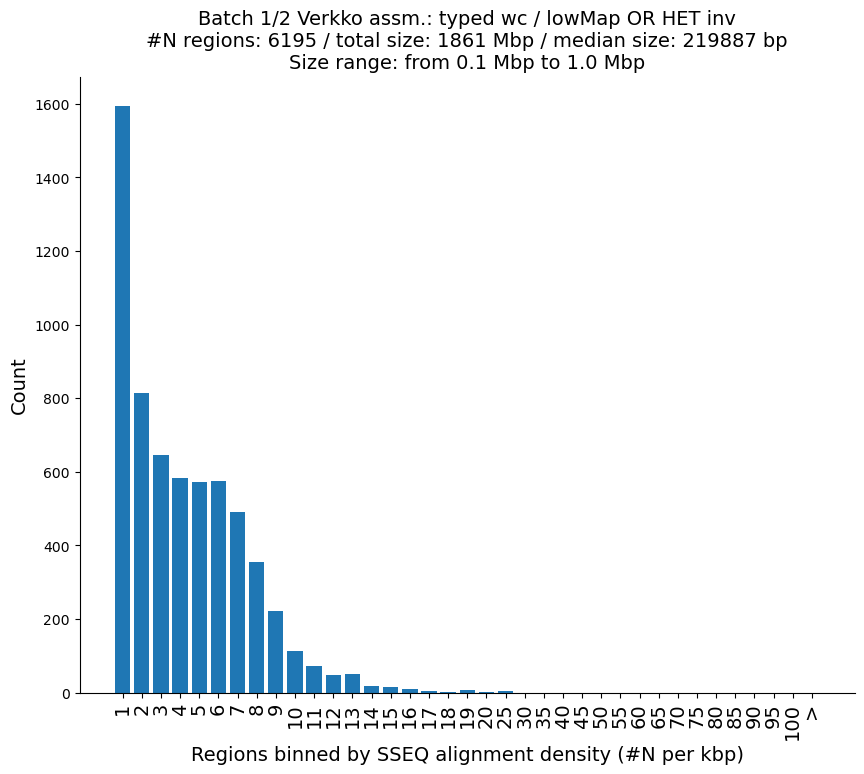

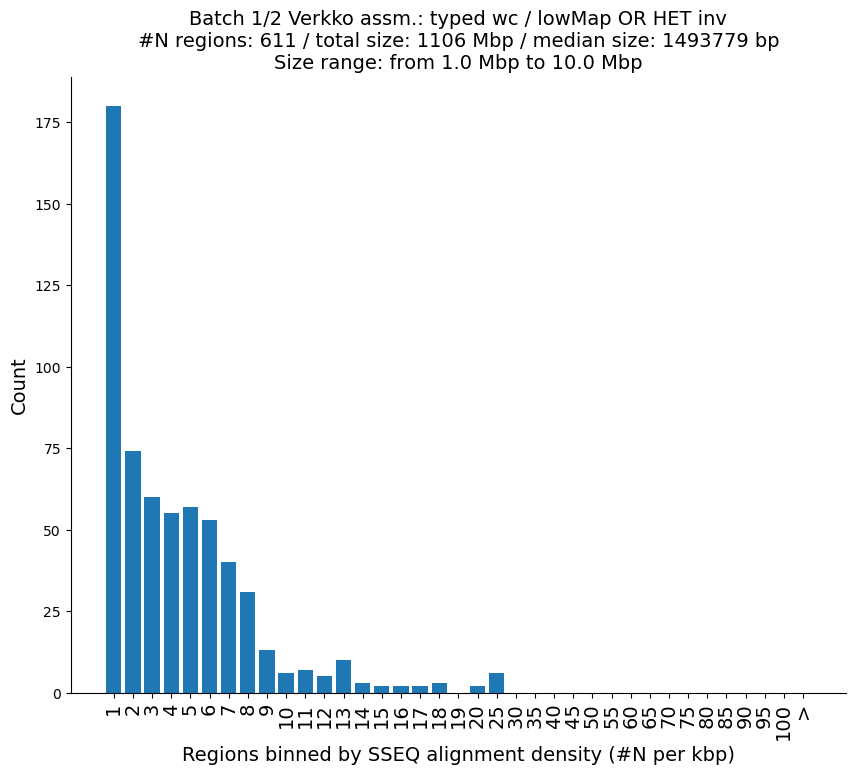

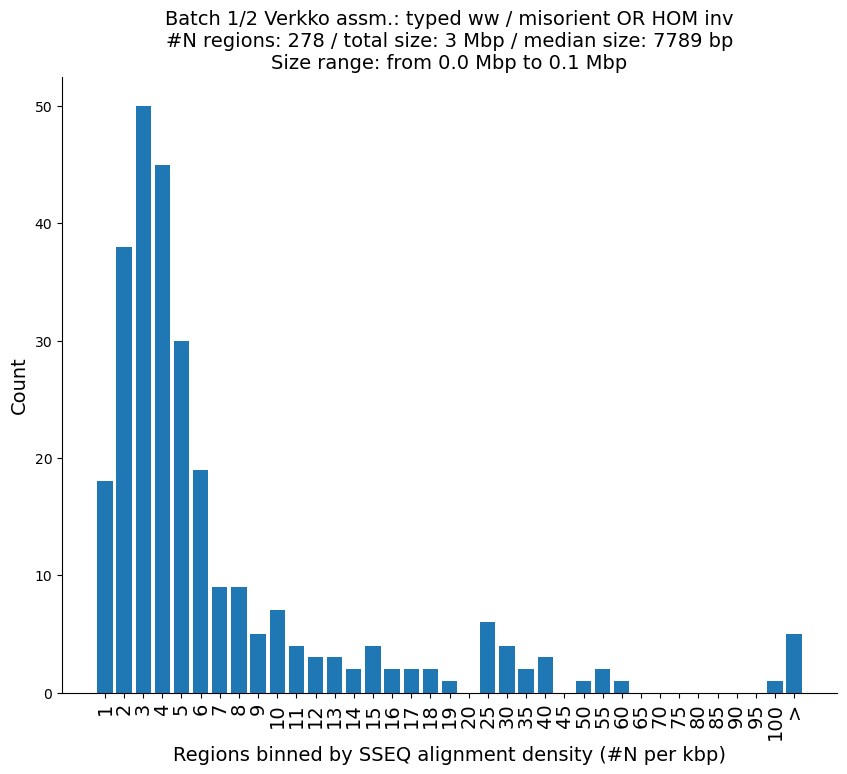

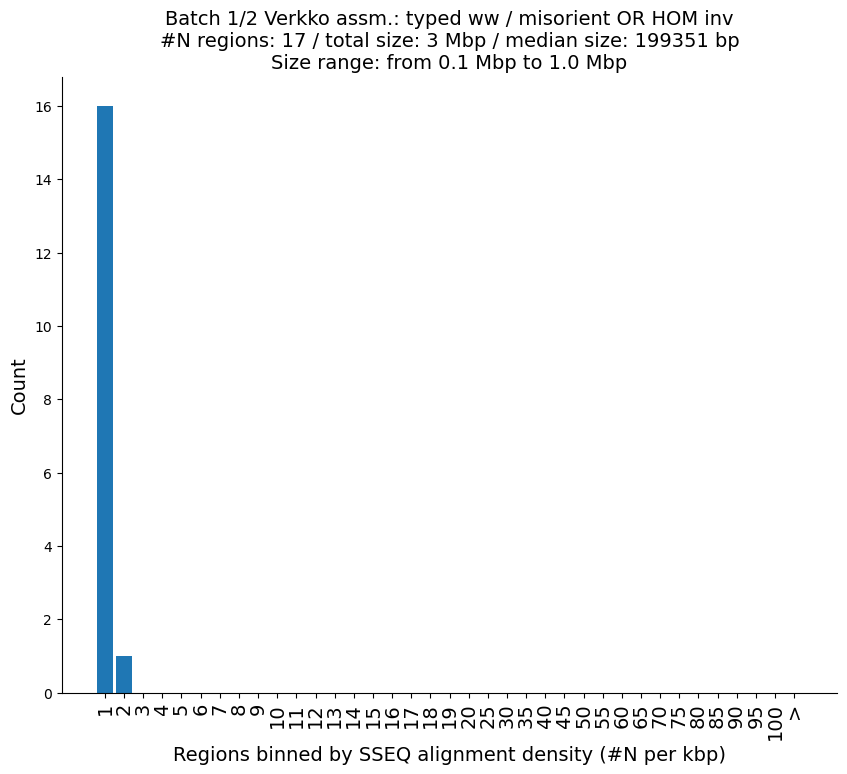

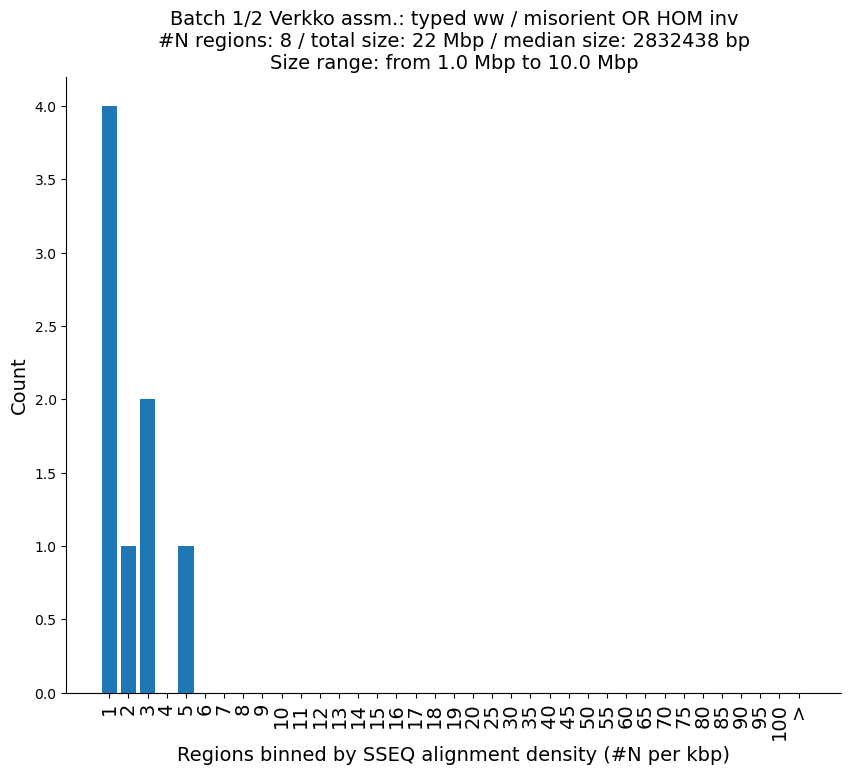

In [7]:
import pandas as pd
import pathlib as pl

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

input_folder = pl.Path("/home/ebertp/work/projects/hgsvc/2023_davidp_sseq_eval")
input_file = input_folder.joinpath("ssq_eval_allRegions.batch1-2.tsv")
output_file = input_folder.joinpath("ssq_eval_allRegions.batch1-2.PEclean.tsv")

def normalize_id(id_field):
    
    garbage, sample_name, hap = id_field.split("_")
    assert garbage == "syncReads"
    assert hap in ["H1", "H2"]
    sample_name = sample_name.replace("GM", "NA")
    return f"{sample_name}_{hap}"

df = pd.read_csv(input_file, sep="\t", header=0)
df["assembly"] = df["ID"].apply(normalize_id)
df = df.rename({"ctg.len": "length", "Ws": "watson", "Cs": "crick"}, axis=1)
df.drop(["ID", "strand"], axis=1, inplace=True)

df["total_align"] = df["watson"] + df["crick"]

df["density_kbp"] = df["total_align"] / df["width"] * 1000

boundaries = list(range(0, 21, 1)) + list(range(25, 105, 5)) + [1000000]

bin_labels = [f"{i}" for i in boundaries[1:-1]] + [">"]

label_explain = {
    "ww": "misorient OR HOM inv",
    "wc": "lowMap OR HET inv"
}

for state, regions in df.groupby("states"):
    
    for size_low, size_high in [(0, int(1e5)), (int(1e5), int(1e6)), (int(1e6), int(1e7))]:

        low_label = round(size_low / 1e6, 1)
        high_label = round(size_high / 1e6, 1)
        
        select_larger = regions["width"] >= size_low
        select_smaller = regions["width"] < size_high
        
        subset = regions.loc[select_larger & select_smaller, :].copy()
        
        num_regions = subset.shape[0]
        total_size = int(subset["width"].sum() / 1e6)
        med_size = int(subset["width"].describe()["50%"])


        hist, bin_edges = np.histogram(
            subset["density_kbp"].values,
            bins=boundaries,
        )

        fig, ax = plt.subplots(figsize=(10,8))

        ax.bar(
            np.arange(hist.size),
            hist,
        )
        ax.set_xticks(np.arange(hist.size))
        ax.set_xticklabels(bin_labels, fontsize=14, rotation=90)

        ax.set_title(
            (
                f"Batch 1/2 Verkko assm.: typed {state} / {label_explain[state]}\n"
                f"#N regions: {num_regions} / total size: {total_size} Mbp / median size: {med_size} bp\n"
                f"Size range: from {low_label} Mbp to {high_label} Mbp"
            ),
            fontsize=14
        )
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_ylabel("Count", fontsize=14)
        ax.set_xlabel("Regions binned by SSEQ alignment density (#N per kbp)", fontsize=14)

    df.to_csv(output_file, sep="\t", header=True, index=False)   
    
    
